Unique users in data: 836
Unique products in data: 54
Sampling 836 users and 54 products...
Sampled data shape: (1177, 3)
Sample unique users: 836
Sample unique products: 54
Pivot shape: (836, 54)
Top recommendations for user: 1-Apr
product
B01KIOU4EO    0.114671
B0117U8JSG    0.039544
B01M3ULMWP    0.033463
B00CX5P8FC    0.026647
B002Y27P3M    0.000000
dtype: float64


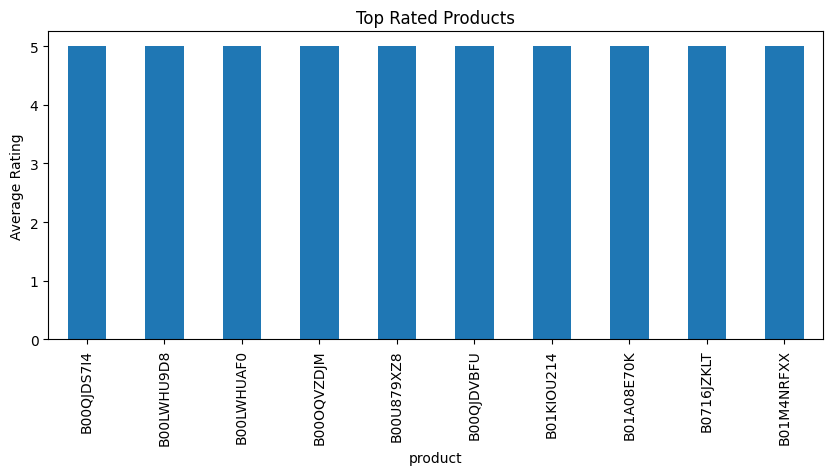

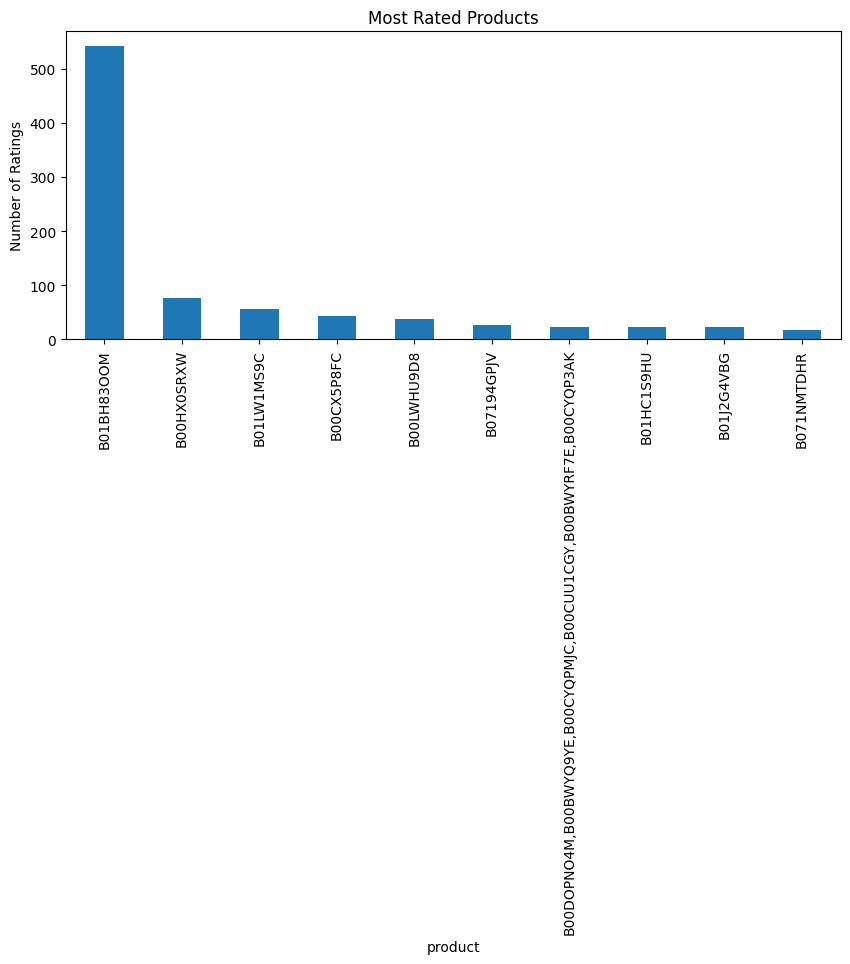

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Step 1: Read and prepare basic data columns
df = pd.read_csv('7817_1.csv')

# Only keep the columns we want
df = df[['reviews.username', 'asins', 'reviews.rating']].copy()
df.rename(columns={'reviews.username': 'user_id', 'asins': 'product', 'reviews.rating': 'rating'}, inplace=True)
df = df.dropna(subset=['user_id', 'product', 'rating'])

# Make ratings numeric
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating'])

# Step 2: Show uniques, in case the data is very small
num_users = df['user_id'].nunique()
num_products = df['product'].nunique()
print("Unique users in data:", num_users)
print("Unique products in data:", num_products)

sample_n_users = min(1000, num_users)
sample_n_products = min(100, num_products)

print(f"Sampling {sample_n_users} users and {sample_n_products} products...")
sample_users = df['user_id'].drop_duplicates().sample(sample_n_users, random_state=42)
sample_products = df['product'].drop_duplicates().sample(sample_n_products, random_state=42)
df_sample = df[(df['user_id'].isin(sample_users)) & (df['product'].isin(sample_products))].copy()

print(f"Sampled data shape: {df_sample.shape}")
print(f"Sample unique users: {df_sample['user_id'].nunique()}")
print(f"Sample unique products: {df_sample['product'].nunique()}")

# Step 3: Pivot and robust handling if empty
if df_sample.empty:
    print("No data after sampling! Try increasing min size or check your dataset.")
else:
    pivot = df_sample.pivot_table(index='user_id', columns='product', values='rating')
    pivot.fillna(0, inplace=True)
    print("Pivot shape:", pivot.shape)

    # Check if the pivot is non-empty
    if pivot.empty:
        print("Pivot table is empty. No recommendations possible with the selected sample.")
    else:
        # Step 4: Similarity calculation
        item_similarity = cosine_similarity(pivot.T)
        sim_df = pd.DataFrame(item_similarity, index=pivot.columns, columns=pivot.columns)

        # Step 5: Recommendation function robust to missing users
        def recommend_products(user_id, pivot_table, similarity_matrix, top_n=5):
            if user_id not in pivot_table.index:
                print(f"User '{user_id}' not found.")
                return []
            user_ratings = pivot_table.loc[user_id]
            scores = similarity_matrix.dot(user_ratings)
            norm = np.abs(similarity_matrix).sum(axis=1)
            # avoid division by zero
            norm[norm == 0] = 1
            scores = scores / norm
            already_rated = user_ratings[user_ratings > 0].index
            recommendations = pd.Series(scores, index=similarity_matrix.index).drop(already_rated)
            return recommendations.sort_values(ascending=False).head(top_n)

        # Try a recommendation only if there are users
        if len(pivot.index) > 0:
            example_user = pivot.index[0]
            print(f"Top recommendations for user: {example_user}")
            print(recommend_products(example_user, pivot, sim_df, top_n=5))
        else:
            print("No users found in pivot table.")

        # Step 6: Optional Visualization
        if df_sample['product'].nunique() > 0:
            plt.figure(figsize=(10,4))
            avg_ratings = df_sample.groupby('product')['rating'].mean().sort_values(ascending=False).head(10)
            avg_ratings.plot(kind='bar', title='Top Rated Products')
            plt.ylabel('Average Rating')
            plt.show()

            plt.figure(figsize=(10,4))
            popularity = df_sample['product'].value_counts().head(10)
            popularity.plot(kind='bar', title='Most Rated Products')
            plt.ylabel('Number of Ratings')
            plt.show()